In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Data/Aviation_Data.csv")

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_5402/2459307861.py:1: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data/Aviation_Data.csv")


In [3]:
def normalize(name, normalized_names):
    for x in normalized_names:
        if x.lower() in str(name).lower():
            return x
    return name

#manufacturers = {"Boeing":"", "Airbus":"Airbus", "Comac":"Comac", "Embraer":"Embraer", 
#"Havilland":"de Havilland", "Britten":"Britten-Norman", "Evektor":"Evektor", "Cessna":"Cessna", "Texas Aircraft":"Texas Aircraft", "Piper":"Piper",
#"Cubcrafters":"Cubcrafters","Beechcraft":"Beechcraft","Diamond":"Diamond",
#"Cirrus":"Cirrus","Bombardier":"Bombardier"}
                        
models_of_interest = pd.DataFrame([["Boeing","737",11762], ["Boeing","767",1311], ["Airbus","A320",11471], ["Airbus","A340", 380], 
["Boeing",'777',1729], ["Airbus","A319",1501], ["Airbus",'A330',1601], ["Airbus","A321",3145],
["Boeing","787",1129], ["Airbus","A350",602], ["Airbus",'A220',335]],columns=["Make","Model","Produced"])

df["Make"]=df["Make"].map(lambda x:str(x))
df.loc["Model"]=df["Model"].map(lambda x:str(x))

df["Make"] = df["Make"].map(lambda x:normalize(x,models_of_interest["Make"].unique()))
df["Model"] = df["Model"].map(lambda x:normalize(x,models_of_interest["Model"].unique()))

df.to_csv("test.csv")

models_of_interest["Make"].unique()


array(['Boeing', 'Airbus'], dtype=object)

In [4]:
filter = df["Make"].map(lambda x:x in models_of_interest["Make"].unique())
df = df[filter]

filter = df["Model"].map(lambda x:x in models_of_interest["Model"].unique())
df = df[filter]

#df[df["Make"]=="Airbus"]


for col in ["Total.Serious.Injuries","Total.Fatal.Injuries"]:
    df[col]=df[col].map(lambda x:0 if np.isnan(x) else int(x))

incidents = df.groupby(["Make","Model"]).count()["Total.Serious.Injuries"]
incidents_injuries=df[df["Total.Serious.Injuries"]>0].groupby(["Make","Model"]).count()["Total.Serious.Injuries"]

incidents_fatal=df[df["Total.Fatal.Injuries"]>0].groupby(["Make","Model"]).count()["Total.Fatal.Injuries"]
injury_total=df.groupby(["Make","Model"]).sum()[["Total.Serious.Injuries","Total.Fatal.Injuries"]]


In [5]:
modelCompare=pd.concat([incidents,incidents_injuries,incidents_fatal,injury_total],axis=1)
modelCompare.columns=["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Total Injuries","Total Fatalities"]

for col in modelCompare.columns:
    modelCompare[col]=modelCompare[col].map(lambda x: 0 if np.isnan(x) else int(x))


produced = models_of_interest.set_index(["Make","Model"])
modelCompare = modelCompare.sort_values(["Make","Model"])
modelCompare = pd.concat([modelCompare,produced], axis=1)


In [6]:
modelCompare["IncidentsRatio"]=modelCompare["Incidents-Any"]/modelCompare["Produced"]
modelCompare["IncidentsFatalitiesRatio"]=modelCompare["Incidents-Fatalities"]/modelCompare["Produced"]
modelCompare["IncidentsInjuriesRatio"]=modelCompare["Incidents-Injuries"]/modelCompare["Produced"]

In [7]:
modelCompare[["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Total Injuries","Total Fatalities","Produced"]]

Incidents-Any  Incidents-Injuries  Incidents-Fatalities  \
Make   Model                                                            
Airbus A220               5                   0                     0   
       A319              52                  15                     0   
       A320             152                  17                    10   
       A321              36                   2                     2   
       A330              63                   6                     2   
       A340               5                   1                     0   
       A350               2                   0                     1   
Boeing 737             1040                 148                    60   
       767              213                  48                     6   
       777              165                  26                     4   
       787               42                   4                     0   

              Total Injuries  Total Fatalities  Produced  
Make   Model                                              
Airbus A220                0                 0       335  
       A319               62                 0      1501  
       A320               96              1027     11471  
       A321                9               381      3145  
       A330               36               331      1601  
       A340                2                 0       380  
       A350                0                 1       602  
Boeing 737              1038              3897     11762  
       767               251               640      1311  
       777               221               538      1729  
       787                12                 0      1129

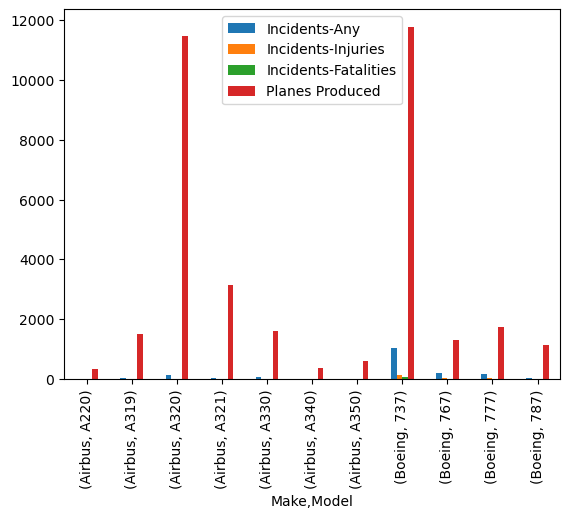

In [8]:
fig, ax = plt.subplots()
modelCompare.plot.bar(y=["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Produced"], ax=ax)
ax.legend(["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Planes Produced"])


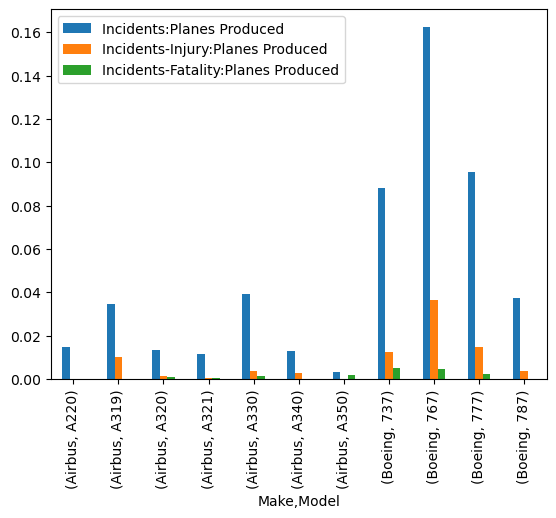

In [9]:
fig, ax = plt.subplots()
modelCompare.plot.bar(y=["IncidentsRatio","IncidentsInjuriesRatio","IncidentsFatalitiesRatio"], ax=ax)
ax.legend(["Incidents:Planes Produced","Incidents-Injury:Planes Produced","Incidents-Fatality:Planes Produced"])